In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.activations import relu, sigmoid 
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,)

import warnings
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

The goal of this project is to classify facial expressions using images from the FER2013 dataset. The binary classification task focuses on distinguishing between positive (happy) and negative (angry, fearful, sad) emotions.

## Base Model Load

In [37]:
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(139, 139, 3))

"""
include_top = False // excluding last classifier layer 
wieghts = 'imagenet' // load pretrained weight from ImageNet dataset 
input_shape = (224,224,3) // Input must be the same format as shown ! 
"""

base_model.trainable = False #Freeze base model - won't be trained on new data set 

## Data Set Load - Binary Classification of positive/negative emotions

In [38]:
df = pd.read_csv('fer2013.csv') #Data load 

pos_emotion = df[df['emotion']==3] # Emotion 3 = Happiness
neg_emotion = df[df['emotion'].isin([0,2,4])] #Emotion 0 = Anger, 2 = Fear, 4 = Sadness

print(pos_emotion.shape)
print(neg_emotion.shape) 

pos_emotion = pos_emotion.sample(8500, random_state=42) #1500 samples per class 1 
neg_emotion = neg_emotion.sample(8500, random_state=42) #1500 samples per class 0

pos_emotion['emotion'] = 1 
neg_emotion['emotion'] = 0

df_EmotionClassification = pd.concat([pos_emotion, neg_emotion]).sample(frac=1, random_state=42).reset_index(drop=True) #Shuffle
df_EmotionClassification = df_EmotionClassification.iloc[:, :-1]
'''
pd.concat([pos_emotion, neg_emotion]) // combine two columns into one data set 
sample(frac=1, random_state=42) // frac=1 (shuffle 100%)
reset_index(drop=True) // set new indices 
'''

print(df_EmotionClassification)


(8989, 3)
(16151, 3)
       emotion                                             pixels
0            0  99 52 71 106 115 124 138 150 159 166 167 167 1...
1            1  23 20 20 16 16 17 15 20 16 16 21 32 27 23 24 2...
2            0  150 153 153 152 153 157 159 159 150 135 134 12...
3            1  237 237 237 237 237 237 237 237 237 237 237 23...
4            1  169 169 166 160 172 169 187 198 172 188 195 19...
...        ...                                                ...
16995        0  114 121 111 116 121 119 122 124 121 122 122 11...
16996        0  168 165 170 170 169 168 167 168 172 77 214 245...
16997        1  210 216 207 194 195 175 126 83 79 128 159 168 ...
16998        1  139 141 141 143 148 126 53 51 53 52 58 68 57 5...
16999        0  20 28 51 53 57 102 130 197 213 218 223 227 229...

[17000 rows x 2 columns]


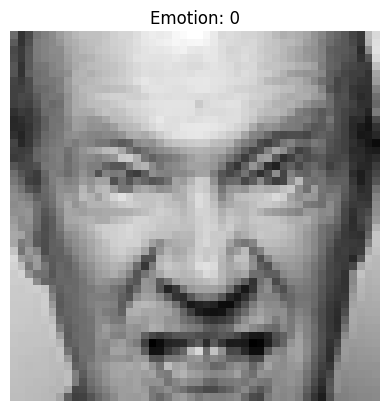

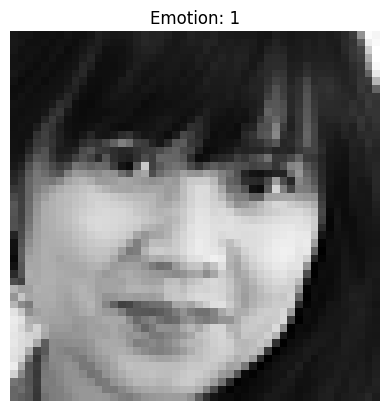

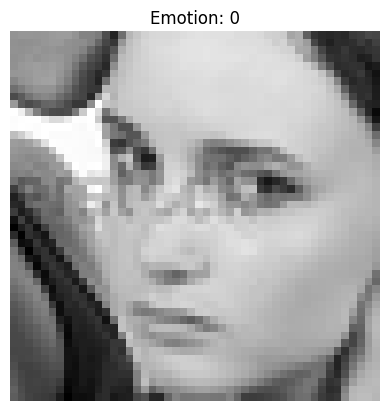

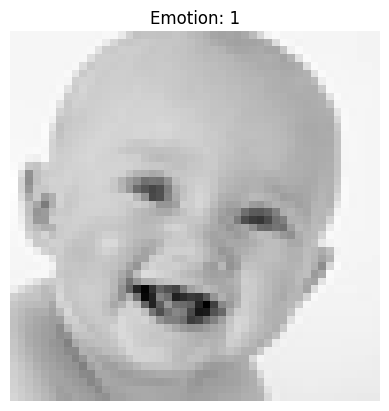

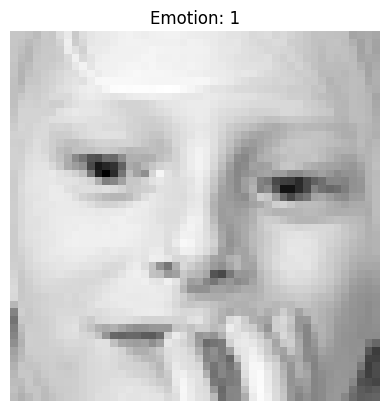

In [39]:
## DATA SET VISUALIZATION

def get_image_from_pixels(pixels):
    image_pixels = list(map(int, pixels.split()))
    image = np.array(image_pixels).reshape(48, 48)
    return image

for index, row in df_EmotionClassification.head(5).iterrows():
    image = get_image_from_pixels(row['pixels'])
    emotion_label = row['emotion']
    
    plt.imshow(image, cmap='gray')
    plt.title(f"Emotion: {emotion_label}")
    plt.axis('off')
    plt.show()

In [40]:
# Feature / class definition
X = df_EmotionClassification['pixels'].values
y = df_EmotionClassification['emotion'].values

print(X)
print(y)

['99 52 71 106 115 124 138 150 159 166 167 167 171 179 184 184 190 199 203 201 203 211 214 218 218 211 201 187 189 186 182 183 178 172 162 152 157 151 145 131 120 103 94 84 67 57 160 187 85 52 75 112 117 122 133 148 154 161 165 167 172 179 181 185 192 198 201 204 206 210 209 210 211 207 200 191 188 185 184 185 179 172 168 161 161 154 140 132 114 100 89 83 71 56 155 191 71 58 82 112 117 124 124 144 151 159 163 169 172 177 180 185 190 195 198 197 200 204 206 199 197 200 197 190 183 184 188 185 176 171 169 160 152 145 133 129 116 91 85 84 77 45 123 193 74 58 84 111 118 121 123 139 151 151 156 164 170 174 178 185 193 196 194 194 195 198 195 192 192 197 197 191 185 185 190 184 179 172 166 159 151 144 135 127 117 92 86 80 74 52 80 186 81 52 84 105 108 118 124 136 148 156 162 164 167 169 175 181 187 192 191 192 195 192 192 188 188 192 196 192 189 183 185 186 174 170 169 164 161 153 149 141 113 93 88 73 68 62 60 165 79 52 89 100 105 118 120 127 154 158 153 160 165 169 175 182 186 191 189 190 1

## Training / Validation data split 

In [41]:
# 60% of the dataset as the training set; the remaining 40% in temporary variables
X_train, x_, y_train, y_ = train_test_split(X, y, test_size=0.40, stratify=y, random_state=42) #stratify -> avoiding uneven split 

# Division 40% subset into two: one half for cross validation and the other for the test set
X_cv, X_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, stratify=y_, random_state=42)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {X_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {X_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {X_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (10200,)
the shape of the training set (target) is: (10200,)

the shape of the cross validation set (input) is: (3400,)
the shape of the cross validation set (target) is: (3400,)

the shape of the test set (input) is: (3400,)
the shape of the test set (target) is: (3400,)


## Data Preprocessing + Normalization

In [42]:
def preprocess_images(pixels):
    img = np.array([int(p) for p in pixels.split()]).reshape(48, 48)
    
    """
    pixels.split() - split text values to list format 
    int(p) for p in pixels.split() - text -> int 
    """

    img = np.expand_dims(img, axis=-1)
    img_resized = tf.image.resize(img, [139, 139])
    img_rgb = tf.repeat(img_resized, 3, axis=-1)
        
    return img_rgb.numpy()


In [43]:
X_norm_train = np.array([preprocess_images(p) for p in X_train])
X_norm_train = X_norm_train.astype('float32')
X_norm_train = preprocess_input(X_norm_train)
print(f'X_norm_train.shape = {X_norm_train.shape}')

X_norm_cv = np.array([preprocess_images(p) for p in X_cv])
X_norm_cv = X_norm_cv.astype('float32')
X_norm_cv  = preprocess_input(X_norm_cv )
print(f'X_norm_cv.shape = {X_norm_cv.shape}')


X_norm_train.shape = (10200, 139, 139, 3)
X_norm_cv.shape = (3400, 139, 139, 3)


## Model definiton

In [44]:
model = Sequential(
    [
        tf.keras.Input(shape=(139, 139, 3)), 
        base_model,
        GlobalAveragePooling2D(),
        Dense(units=128, activation='relu', name='layer1', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.5), 
        Dense(units=64, activation='relu', name='layer2', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dense(units=1, activation='sigmoid', name='output', kernel_regularizer=tf.keras.regularizers.l2(0.001))
    ], 
    name="emotion_classifier"
)



In [45]:
model.summary()

Model: "emotion_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 3, 3, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,541,793 (208.06 MB)

 Trainable params: 205,057 (801.00 KB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [46]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=['accuracy']
)

In [47]:
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    restore_best_weights = True,
    verbose = 1)

## TRAINING STAGE

In [50]:
model_1 = model.fit(
    X_norm_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_norm_cv, y_cv),
    callbacks=early_stop,
    verbose=1
)

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.6075 - loss: 1.0366 - val_accuracy: 0.7256 - val_loss: 0.8036
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.7081 - loss: 0.8028 - val_accuracy: 0.7353 - val_loss: 0.7317
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.7228 - loss: 0.7358 - val_accuracy: 0.7494 - val_loss: 0.6790
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.7302 - loss: 0.6927 - val_accuracy: 0.7535 - val_loss: 0.6483
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - accuracy: 0.7379 - loss: 0.6544 - val_accuracy: 0.7550 - val_loss: 0.6156
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.7352 - loss: 0.6323 - val_accuracy: 0.7635 - val_loss: 0.6016
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - accuracy: 0.7515 - loss: 0.5971 - val_accuracy: 0.7653 - val_loss: 0.5838
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.7490 - loss: 0.5854 - val_accuracy: 0.7765 - v

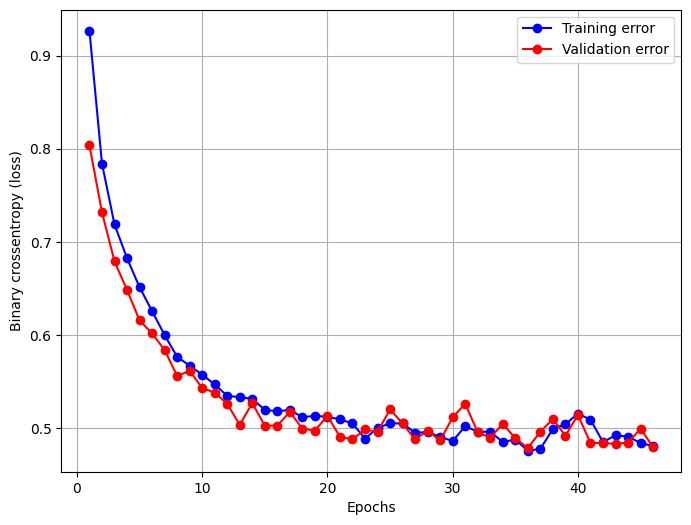

In [51]:
history_dict = model_1.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training error')
plt.plot(epochs, val_loss, 'ro-', label='Validation error')
plt.xlabel('Epochs')
plt.ylabel('Binary crossentropy (loss)')
plt.legend()
plt.grid(True)
plt.show()

* both training and validation losses steadily decrease -> learning and convergence
* *no significant overfitting

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step


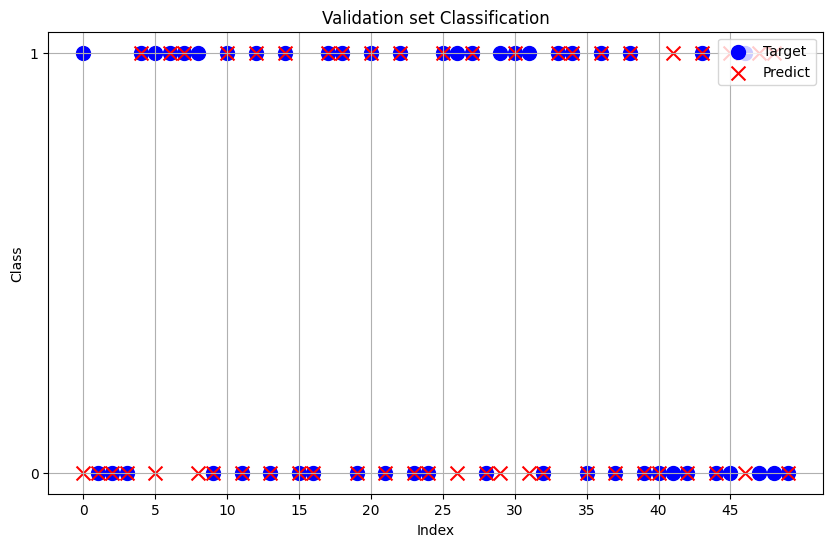

In [52]:
y_cv_pred_probs = model.predict(X_norm_cv[:50])
y_cv_pred = (y_cv_pred_probs > 0.5).astype("int32")

y_cv_true = y_cv[:50]

# Tworzenie wykresu
plt.figure(figsize=(10, 6))
indices = np.arange(50)

plt.scatter(indices, y_cv_true, color='blue', label='Target', marker='o', s=100)
plt.scatter(indices, y_cv_pred, color='red', label='Predict', marker='x', s=100)

plt.title('Validation set Classification')
plt.xlabel('Index')
plt.ylabel('Class')
plt.xticks(np.arange(0, 50, step=5))
plt.yticks([0, 1], ['0', '1'])
plt.legend(loc="upper right")

plt.grid(True)
plt.show()

107/107 ━━━━━━━━━━━━━━━━━━━━ 88s 825ms/step


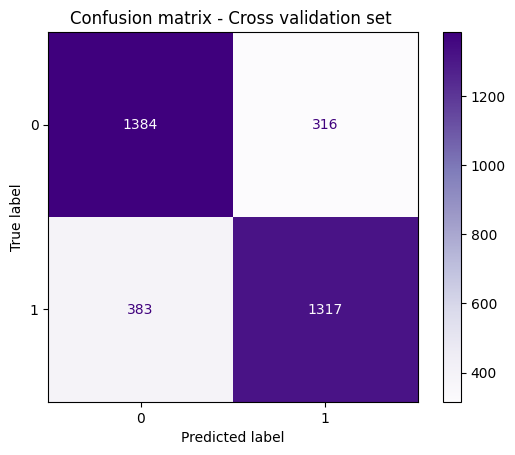

In [53]:
y_cv_pred_probs = model.predict(X_norm_cv)
y_cv_pred = (y_cv_pred_probs > 0.5).astype("int32") #threshold = 0.5
cm = confusion_matrix(y_cv, y_cv_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
disp.plot(cmap='Purples')
plt.title("Confusion matrix - Cross validation set ")
plt.show()

* TN: 1384
* FP: 316
* FN: 383
* TP: 1317

In [54]:
accuracy = accuracy_score(y_cv, y_cv_pred)
print(f"Accuracy on validation set:  {accuracy:.4f}")
precision = precision_score(y_cv, y_cv_pred)
print(f"Precision on validation set: {precision:.4f}")
recall = recall_score(y_cv, y_cv_pred)
print(f"Recall on validation set:    {recall:.4f}")
f1 = f1_score(y_cv, y_cv_pred)
print(f"F1 Score on validation set:  {f1:.4f}")

Accuracy on validation set:  0.7944
Precision on validation set: 0.8065
Recall on validation set:    0.7747
F1 Score on validation set:  0.7903


* ACCURACY: 79% were correct
* PRECISION: 81% of actual positives were correctly identified
* F1 SCORE: 79% harmonic mean between precision and recall

## Comparison with the state of the art

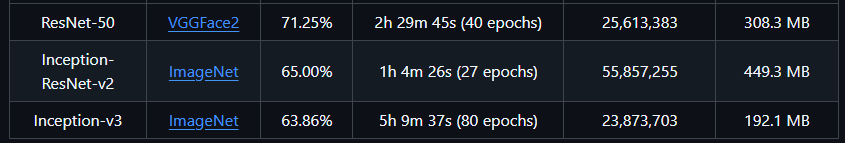

## Mine model
InceptionResNetV2   |   ImageNet     |  79% (accuracy)  | 

BIG PROBLEM: not fair to compare binary classification problem with multiclass one !